In [309]:
import pandas as pd
import numpy as np
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.style as style
from datetime import date, datetime, timedelta
%matplotlib inline

'https://data.austintexas.gov/Transportation-and-Mobility/Austin-B-Cycle-Trips/tyfh-5r8s'
kiosk = pd.read_csv(r"~/Documents/datasets/coa/Austin_B-Cycle_Kiosk_Locations.csv")
trips = pd.read_csv(r"~/Documents/datasets/coa/Austin_B-Cycle_trips excel.csv")

print(kiosk.head())
print(trips.head())

Kiosk ID                   Kiosk Name Kiosk Status  Latitude  Longitude  \
0      3793            Rio Grande & 28th       active  30.29333  -97.74412   
1      3291           11th & San Jacinto       active  30.27193  -97.73854   
2      4058  Hollow Creek & Barton Hills       active  30.26139  -97.77234   
3      3797            21st & University       active  30.28354  -97.73953   
4      2546     ACC - West & 12th Street       closed  30.27624  -97.74831   

                Location  
0  (30.29333, -97.74412)  
1  (30.27193, -97.73854)  
2  (30.26139, -97.77234)  
3  (30.28354, -97.73953)  
4  (30.27624, -97.74831)  
      Trip ID                     Membership Type Bicycle ID Checkout Date  \
0  9900285854        Annual (San Antonio B-cycle)        207    10/26/2014   
1  9900285855      24-Hour Kiosk (Austin B-cycle)        969    10/26/2014   
2  9900285856  Annual Membership (Austin B-cycle)        214    10/26/2014   
3  9900285857      24-Hour Kiosk (Austin B-cycle)        745

In [310]:
# Reccommendations (for conclusion)
# It would be tremendously beneficial for the company to track user data/demographics, to target advertising etc
# It is not within this projects budget to use an API to include weather data, but could be useful to see how much of an impact Austin's weather has on BCycle use
# Incentive for riders to reverse high traffic flows. Rebalancing is inefficient financially and environmentally
trips.columns

Index(['Trip ID', 'Membership Type', 'Bicycle ID', 'Checkout Date',
       'Checkout Time', 'Checkout Kiosk ID', 'Checkout Kiosk',
       'Return Kiosk ID', 'Return Kiosk', 'Trip Duration Minutes', 'Month',
       'Year'],
      dtype='object')

In [311]:
# Data cleaning
kiosk_df = pd.read_csv(r"~/Documents/datasets/coa/Austin_B-Cycle_Kiosk_Locations.csv")

# drop redundant 'Location' column and change 'name' column to 'location'
kiosk_df = kiosk_df.drop(columns='Location')

# format column names
kiosk_df.columns = ['id', 'location', 'status', 'latitude', 'longitude']


In [312]:
# Data cleaning
# Format column names
trips.columns = ['trip_id','membership_type','bicycle_id','checkout_date','checkout_time','checkout_kiosk_id','checkout_kiosk','return_kiosk_id','return_kiosk','trip_length_minutes','month','year']



In [313]:

print(len(pd.unique(trips[['checkout_kiosk', 'return_kiosk']].values.ravel('K'))))
print(len(kiosk))
print(trips['checkout_kiosk'].unique())

195
96
['West & 6th St.' 'Convention Center / 4th St. @ MetroRail'
 'Zilker Park at Barton Springs & William Barton Drive'
 'Bullock Museum @ Congress & MLK' '8th & Congress'
 'East 11th St. & San Marcos' 'South Congress & Elizabeth'
 'Pfluger Bridge @ W 2nd Street' 'Riverside @ S. Lamar' '2nd & Congress'
 'Convention Center/ 3rd & Trinity' 'East 6th at Robert Martinez'
 'East 6th & Pedernales St.' 'Davis at Rainey Street'
 'UT West Mall @ Guadalupe' 'East 11th Street at Victory Grill'
 'Palmer Auditorium' 'State Capitol Visitors Garage @ San Jacinto & 12th'
 '4th/Congress' 'Rainey St @ Cummings' '5th & Bowie'
 'Long Center @ South 1st & Riverside' '17th & Guadalupe'
 'Red River & 8th Street' 'Barton Springs Pool'
 'State Capitol @ 14th & Colorado'
 'Capital Metro HQ - East 5th at Broadway' '3rd & West'
 'South Congress & James' 'Barton Springs @ Kinney Ave'
 'City Hall / Lavaca & 2nd' 'ACC - Rio Grande & 12th' 'Guadalupe & 21st'
 '4th & Congress' 'South Congress & Academy' 'Barton Spr

We see that there are 172 unique kiosks locations in the trips dataframe but only 96 kiosks total in the kiosk dataframe. There are many entries that should be consolidated, for example, many similar instances of "21st/Speedway @PCL" and "21st & Speedway @PCL". We will implement some string parsing to transform the string into a more uniform format. We will also consolidate kiosks when possible.

In [314]:
#s

In [315]:
def format_string(series):     
    '''
    Use: 
        formats string of a pd.Series with data specific guidelines
    Input:
        pd.Series
    Returns:
        The same p.Series after transformation
    '''
    series = (series.str.lower()
                    .str.replace("s\.","south")
                    .str.replace("\.", "")
                    .str.replace(" st ", " ")
                    .str.replace(" street| st$|the|ave|drive", "")
                    .str.replace("/", " & ")
                    .str.replace("@ ", "& ")
                    .str.replace(" $", "")
                    .str.replace("  ", " ")
                    .str.replace(" at "," & "))
    
    # Consolidate 'Office/Main/Shop/Repair' and Missing/Stolen entries
    series = series.replace({'repair shop': 'office & main & shop & repair',
                            'main office': 'office & main & shop & repair',
                            'shop': 'office & main & shop & repair',
                            'main shop': 'office & main & shop & repair',
                            'missing': 'missing or stolen',
                            'stolen': 'missing or stolen'})
    return series

kiosk_df['location'] = format_string(kiosk_df['location'])
trips['checkout_kiosk'] = format_string(trips['checkout_kiosk'])
trips['return_kiosk'] = format_string(trips['return_kiosk'])

We have dealt with a lot of the duplicates, however there are still many instances of duplicates where the streets are in reverse order (Ex. '6th & West' and 'West & 6th'). These can be consolidated as well.


In [316]:
unique_kiosks = list(pd.unique(trips[['checkout_kiosk', 'return_kiosk']].values.ravel('K')))
duplicates = {}

for kiosk in unique_kiosks:
    split_string = kiosk.split(" ")
    unique_kiosks.remove(kiosk)
    
    for kiosk in unique_kiosks:
        counter=0
        for word in split_string:       
            if (word in kiosk) and (len(split_string) == len(kiosk.split(" "))):
                counter += 1
                if counter == len(split_string):
                    duplicates[kiosk] = " ".join(split_string)

print(duplicates)

trips['checkout_kiosk'] = trips['checkout_kiosk'].replace(duplicates)
trips['return_kiosk'] = trips['return_kiosk'].replace(duplicates)

print(len(pd.unique(trips[['checkout_kiosk', 'return_kiosk']].values.ravel('K'))))

{'6th & west': 'west & 6th', '3rd & trinity & convention center': 'convention center & 3rd & trinity', '2nd & lavaca & city hall': 'city hall & lavaca & 2nd', '21st & guadalupe': 'guadalupe & 21st', '6th & trinity': 'trinity & 6th', '3rd & nueces': 'nueces & 3rd', '6th & brazos': 'brazos & 6th', 'east 6th & medina': 'medina & east 6th', 'long center & south 1st & riverside': 'south 1st & riverside & long center', 'henderson & 9th': '9th & henderson', 'lavaca & 6th': '6th & lavaca', 'cesar chz & congress': 'congress & cesar chz', 'rio grande & 28th': '28th & rio grande', 'nueces & 26th': '26th & nueces', 'red river & 8th': '8th & red river'}
129


In [317]:

def find_duplicate_kiosks(series_to_check, baseline_series=None):  
    '''
    Use:
        function checks for duplicate entries (entries that are the same words but in different order). Can be sole argument to check against itself or you can add optional argument as the baseline to check against.
    Input(s):
        one or two pd.Series
    Returns:
          If a baseline series is given, function returns a series that consolidates duplicate entries to match it's baseline counterpart. If no baseline is provided, the duplicate entries are removed and the amended series is returned
    '''
    duplicates = {}
    if baseline_series is not None:
        baseline = list(baseline_series.unique())
    else:
        baseline = list(series_to_check.unique())

    kiosks_to_check = list(series_to_check.unique())

    for kc in kiosks_to_check:         # isolate each kiosk
        split_string = kc.split(" ")
        try:
            baseline.remove(kc)     # remove current kiosk from baseline list so it doesn't match with its own instance
        except ValueError:
            pass

        for b in baseline:#             
            counter = 0
            for word in split_string:
                if len(split_string) != len(b.split(" ")):  # skip kiosk if the two items don't have the same number of words
                    break     
                if word in b:
                    counter += 1
                    if (word == split_string[-1]) and (counter == len(b.split(" "))):   # If the last word has been tested and they are all matches, then add to duplicates
                        duplicates[" ".join(split_string)] = b
    return series_to_check.replace(duplicates)

# first run find_duplicate_kiosks with the series checked against itself to consolidate duplicates within its own column
trips['checkout_kiosk'] = find_duplicate_kiosks(trips['checkout_kiosk'])
trips['return_kiosk'] = find_duplicate_kiosks(trips['return_kiosk'])

# run find_duplicate_kiosks against kiosk_df to sync kiosk names to the names in kiosk_df
trips['checkout_kiosk'] = find_duplicate_kiosks(trips['checkout_kiosk'], kiosk_df['location'])
trips['return_kiosk'] = find_duplicate_kiosks(trips['return_kiosk'], kiosk_df['location'])

# Display the entries in 'checkout_kiosk' and 'return_kiosk' that still to not have matches in the kiosk_df dataframe
unique_checkout_kiosks = trips['checkout_kiosk'].unique()
unique_return_kiosks = trips['return_kiosk'].unique()

unique_checkout_and_return = set(np.concatenate([unique_checkout_kiosks, unique_return_kiosks]))
unique_kiosk_df = set(kiosk_df['location'].unique())

print(unique_checkout_and_return - unique_kiosk_df)

{'veterans & atlanta & mopac ped bridge', 'electric & sandra muraida way & pfluger ped bridge', 'mapjam & hops & grain brewery', '4th & neches & metrorail downtown', "eeyore's 2018", 'guadalupe & west mall & university co-op', 'mobile station & unplugged', 'barton springs & bouldin & palmer auditorium', 'mobile station & bike fest', 'mapjam & scoot inn', 'nash hernandez & east & rbj south', 'missing or stolen', 'mapjam & pan am park', 'republic square & federal courthouse plaza', 'acl 2019 drop off', 'east 6th & robert t martinez', 'fantasy zilker', 'mobile station & boardwalk opening ceremony', 'mobile station', 're-branding', 'guadalupe & 6th', 'zilker park & barton springs & william barton', 'marketing event', '21st & speedway & pcl', 'east 5th & broadway & capital metro hq', 'earth day atx 2017', "eeyore's 2017", 'customer service', 'mapjam & french legation', '11th & congress & texas capitol'}


We have successfully dealt with most of the problematic formatting that the initial dataset had. There are still some kiosks that are not in the kiosk_df dataframe at all and a few fringe cases that weren't caught by string formatting, which we will deal with manually.

In [318]:
for col in ['checkout_kiosk','return_kiosk']:
    trips[col] = trips[col].replace({'barton springs & bouldin & palmer auditorium': 'palmer auditorium', 
                                    '21st & speedway & pcl': '21st & speedway @pcl',
                                    'east 5th & broadway & capital metro hq': 'capital metro hq - east 5th & broadway',
                                    'veterans & atlanta & mopac ped bridge': 'mopac pedestrian bridge & veterans',
                                    'east 6th & robert t martinez': 'east 6th & robert martinez',
                                    'guadalupe & west mall & university co-op': 'ut west mall & guadalupe',
                                    '11th & congress & texas capitol': 'capitol station & congress & 11th',
                                    'nash hernandez & east & rbj south': 'nash hernandez & rbj south',
                                    '4th & neches & metrorail downtown': 'convention center & 4th & metrorail'})

In [319]:
# Make a list of all checkout and return locations without a matching id
checkout_kiosk_need_id = trips[trips['checkout_kiosk_id'].isna()]['checkout_kiosk'].unique()
return_kiosk_need_id = trips[trips['return_kiosk_id'].isna()]['return_kiosk'].unique()
checkout_and_return_need_id = set(np.concatenate([checkout_kiosk_need_id, return_kiosk_need_id]))

# Replace NaNs with proper id
ids_to_assign = {}
for index, location in enumerate(checkout_and_return_need_id):
    if location in kiosk_df['location'].unique():                     # If id is located in kiosk_df, assign that id
        ids_to_assign[location] = kiosk_df[kiosk_df['location'] == location]['id'].values[0]
    else:
        ids_to_assign[location] = '00' + str(index + 10)                           # Else create new 4 digit id

for location in ids_to_assign:
    for col in ['checkout_kiosk', 'return_kiosk']:
        trips.loc[(trips[col+'_id'].isna()) & (trips[col] == location), col+'_id'] = ids_to_assign[location]

Now the two dataframes have the same kiosk id's where possible, and we've transformed the data to a uniform format. We still have columns with NA values to deal with.

In [320]:
# View remaining NaNs
for col in trips.columns:
    print(col, trips[col].isna().sum())



trip_id 0
membership_type 6499
bicycle_id 723
checkout_date 0
checkout_time 0
checkout_kiosk_id 0
checkout_kiosk 0
return_kiosk_id 0
return_kiosk 0
trip_length_minutes 0
month 598326
year 598326


We will fill the NA values for membership_type with 'unknown' and leave bicycle_id as is for now. The month and year columns can be extracted from the checkout_date column.

In [321]:
# Fill na with 'unknown' for membership_type and bicycle_id
trips['membership_type'] = trips['membership_type'].fillna('unknown')

# Format the checkout_date column to prepare for extraction
trips['checkout_date'] = pd.to_datetime(trips['checkout_date'], infer_datetime_format=True)

# Format the year column and extract info from checkout_date
trips['year'] = trips['year'].str.replace(',', '')
trips['month'] = trips['month'].fillna(trips['checkout_date'].dt.month).astype(int)
trips['year'] = trips['year'].fillna(trips['checkout_date'].dt.year).astype(int)

We also need to make sure the remaining columns are formatted correctly.

In [322]:
# Change columns to proper dtype
print(trips.dtypes)

trips['trip_length_minutes'] = trips['trip_length_minutes'].str.replace(',', '')
trips['trip_length_minutes'] = trips['trip_length_minutes'].astype(int)

# Convert time to datetime and add hour column
trips['checkout_time'] = pd.to_datetime(trips['checkout_time'], format='%H:%M:%S').dt.time
trips['hour'] = [x.hour for x in trips['checkout_time']]

# Add day of the week column
trips['weekday'] = trips['checkout_date'].dt.weekday.map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday',5:'Saturday', 6:'Sunday'})

print(trips.dtypes)

trip_id                         int64
membership_type                object
bicycle_id                     object
checkout_date          datetime64[ns]
checkout_time                  object
checkout_kiosk_id              object
checkout_kiosk                 object
return_kiosk_id                object
return_kiosk                   object
trip_length_minutes            object
month                           int32
year                            int32
dtype: object
trip_id                         int64
membership_type                object
bicycle_id                     object
checkout_date          datetime64[ns]
checkout_time                  object
checkout_kiosk_id              object
checkout_kiosk                 object
return_kiosk_id                object
return_kiosk                   object
trip_length_minutes             int32
month                           int32
year                            int32
hour                            int64
weekday                        objec

Upon inspection of the data, we notice that entries in the checkout_time column are all in the format 'HH:12:SS' for trip_id's that are 10 digits (all checkout_times are timestamped at 12 minutes after the hour), while the 7 or 8 digit trip_id's vary as expected . This is surely inaccurate. The 10 digit trip_id's are phased out on 01/03/2016. We can only assume that trip length was derived from the checkout_time, and therefore the trip_length's on the 10 digit trip_id entries are not necessarily valid. We also notice that nearly 80% of bicycle_id NaN's are in this data, which compromises the data's overall integrity even more. This is a significant amount of data that we would like to preserve, but trip_length_minutes is a vital metric for this study. We will omit these entries.

In [323]:
bad_timestamps = trips[trips['trip_id'].astype(str).str.len() == 10]
print(bad_timestamps)
print("Percent of bicycle_id NAs: ", bad_timestamps['bicycle_id'].isna().sum() / trips['bicycle_id'].isna().sum())

trip_id                     membership_type bicycle_id  \
0       9900285854        Annual (San Antonio B-cycle)        207   
1       9900285855      24-Hour Kiosk (Austin B-cycle)        969   
2       9900285856  Annual Membership (Austin B-cycle)        214   
3       9900285857      24-Hour Kiosk (Austin B-cycle)        745   
4       9900285858      24-Hour Kiosk (Austin B-cycle)        164   
5       9900285859      24-Hour Kiosk (Austin B-cycle)         37   
6       9900285860  Annual Membership (Austin B-cycle)        517   
7       9900285861  Annual Membership (Austin B-cycle)        996   
8       9900285862  Annual Membership (Austin B-cycle)        517   
9       9900285863      24-Hour Kiosk (Austin B-cycle)        385   
10      9900285864  Annual Membership (Austin B-cycle)        133   
11      9900285865      24-Hour Kiosk (Austin B-cycle)         52   
12      9900285866      24-Hour Kiosk (Austin B-cycle)        206   
13      9900285867      24-Hour Kiosk (Austin

In [324]:
# Remove 10 digit trip_id's
trips = trips[trips['trip_id'].astype(str).str.len() != 10]

# Inspect for more erroneous data
print("Minimum Trip Length:", trips['trip_length_minutes'].min())
print("Maximum Trip Length:", trips['trip_length_minutes'].max())
print((trips['trip_length_minutes'] == 0).sum())


Minimum Trip Length: 0
Maximum Trip Length: 34238
14901


There are 14,901 entries that have a trip length of 0 minutes, which may be caused by a user and/or kiosk error while checking out a bicycle.
We will remove these entries from the main dataset, but preserve them in a separate dataframe. They may be useful for troubleshooting.

In [325]:
# Separate zero minute trips
zero_min_trips = trips[trips['trip_length_minutes'] == 0]
trips = trips[trips['trip_length_minutes'] != 0]

We can also look into very short trips, of which there are many. The vast majority of these very short trips start and end at the same station, again indicating some sort of user and/or kiosk error. We will set aside these trips as well. Perhaps we can find correlations with the problematic trips and kiosk location.

In [326]:
short_trips = trips[(trips['trip_length_minutes'] < 8) & (trips['checkout_kiosk'] == trips['return_kiosk'])]
trips = trips[(trips['trip_length_minutes'] >= 8) | (trips['checkout_kiosk'] != trips['return_kiosk'])]



Now we will handle the excessively long trips. A few of these entries are the result of return_kiosk's labelled as 'Missing or Stolen.' Those can be removed. We will also assume that trips lasting more than 24 hours are erroneous and remove those and examine the remaining entries.

(-33.238, 3424.7]     821116
(3424.7, 6848.4]         107
(6848.4, 10272.1]         18
(10272.1, 13695.8]         9
(13695.8, 17119.5]         3
(17119.5, 20543.2]         0
(20543.2, 23966.9]         2
(23966.9, 27390.6]         0
(27390.6, 30814.3]         0
(30814.3, 34238.0]         1
Name: trip_length_minutes, dtype: int64


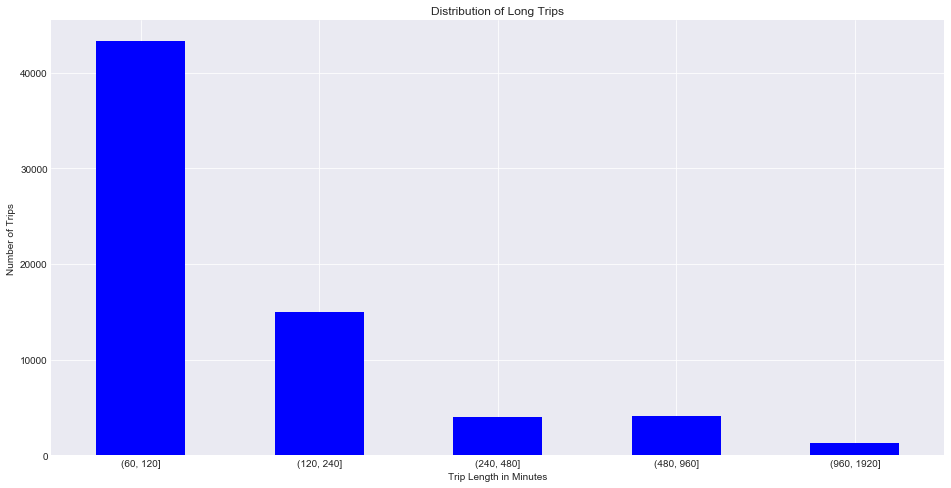

In [327]:
print(trips['trip_length_minutes'].value_counts(bins=10).sort_index())

missing_or_stolen = trips[trips['return_kiosk'] == 'missing or stolen']
trips = trips[trips['return_kiosk'] != 'missing or stolen']

long_trips = trips[trips['trip_length_minutes'] > 1440]
trips = trips[trips['trip_length_minutes'] <= 1440]

# plot distribution of remaining long trips
out = pd.cut(trips[trips['trip_length_minutes'] > 60]['trip_length_minutes'], bins=[60, 120, 240, 480, 960, 1920])
ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(16, 8))
ax.set_xlabel('Trip Length in Minutes')
ax.set_ylabel('Number of Trips')
ax.set_title('Distribution of Long Trips')
plt.show()


Making further cuts will be more subjective. While there are subscription passes and 24 hour passes, all of these passes state that users have unlimited access to bikes but are charged extra for trips lasting more than 60 minutes, indicating that most users would be incentivized to keep their trips short and swap out bikes for longer trips. From reading reviews of BCycles, many users have claimed that these instructions are not clear, and that they thought that they had unlimited use for 24 hours. We will investigate this later. 
A trip lasting 5 hours costs $70 for walk up users, the same cost as taking many uber rides throughout the day. It is difficult to tell which trips are genuine long trips and which trips are a result of error by the user or system (Ex. bike is not properly docked at kiosk, which users also reported as an issue). In the plot above we see a sharp drop off in rides longer than 120 minutes, and another sharp drop off after 240 minutes (note the logarithmic scale). Setting a cap of 300 minutes looks like a good balance of capturing some natural outliers while at the same time filtering out erroneous long trips. 
If we filter the data by trips lasting longer than 300 minutes and sort by date/time, we see many peculiar results. In one instance, there is a block of 5 trips all checking out at the same location in the same minute, lasting 1095 minutes, and returning at the same location. This is surely erroneous. We will remove all trips lasting longer than 300 minutes.

In [328]:
print(trips[trips['trip_length_minutes'] > 300].sort_values(['checkout_date','checkout_time']))
print(trips.loc[[1091321, 1089197, 1087709, 1089198, 1087632]])

alk Up        503    2016-01-06   
330726    8338996                        Walk Up        453    2016-01-08   
330783    8350290                        Walk Up        507    2016-01-08   
330846    8351495                        Walk Up        371    2016-01-08   
330820    8351547                       Local365        558    2016-01-08   
329788    8376068                        Walk Up        610    2016-01-11   
329415    8388174                        Walk Up        578    2016-01-12   
328984    8401856                        Walk Up        561    2016-01-13   
329156    8403526                        Walk Up        958    2016-01-13   
328971    8404620                       Local365        522    2016-01-13   
328700    8410683                        Walk Up        356    2016-01-14   
328550    8410690                        Walk Up        183    2016-01-14   
328832    8415821                        Walk Up        979    2016-01-14   
328075    8428943                        

In [329]:
# add trips over 300 minutes to the dataframe containing trips over 1440 minutes
long_trips = pd.concat([long_trips, trips[trips['trip_length_minutes'] > 300]], axis=0)

# reduce trips dataframe to drips less than 300 minutes
trips = trips[trips['trip_length_minutes'] <= 300]

# Inspect distribution of kiosks for long trips
print(long_trips['checkout_kiosk'].value_counts())

21st & speedway @pcl                                           861
guadalupe & 21st                                               294
dean keeton & speedway                                         261
davis & rainey                                                 247
riverside & south lamar                                        238
rainey & cummings                                              225
rio grande & 28th                                              217
brazos & 6th                                                   209
ut west mall & guadalupe                                       198
23rd & rio grande                                              194
nueces & 26th                                                  192
capitol station & congress & 11th                              175
21st & university                                              163
city hall & lavaca & 2nd                                       160
22nd & pearl                                                  

Next we take a look at membship_type to see if any data cleaning is necessary.

In [330]:
print(trips['membership_type'].unique())

['unknown' 'Walk Up' 'Local365' 'Local365+Guest Pass' 'Local30'
 'Weekender' 'Explorer' 'Founding Member' 'Annual'
 'Local365 Youth with helmet (age 13-17 riders)' 'Annual Membership'
 'Annual Member' 'Republic Rider (Annual)' 'Annual Pass' 'Annual Plus'
 'Try Before You Buy Special' 'Membership: pay once  one-year commitment'
 'Local365 ($80 plus tax)' 'Denver B-cycle Founder' 'Republic Rider'
 '7-Day' 'Local30 ($11 plus tax)' 'Weekender ($15 plus tax)'
 'Explorer ($8 plus tax)' 'RESTRICTED' 'Annual '
 'Local365 Youth (age 13-17 riders)' 'U.T. Student Membership'
 'UT Student Membership' 'Madtown Monthly' 'Annual Plus Membership'
 'Aluminum Access' 'HT Ram Membership' '3-Day Weekender'
 '24 Hour Walk Up Pass' '3-Day Explorer' '$1 Pay by Trip Fall Special'
 'Single Trip' 'Pay-as-you-ride' 'Single Trip (Pay-as-you-ride)'
 'ACL 2019 Pass' 'Single Trip Ride'
 'Local365- 1/2 off Anniversary Special'
 'Local365+Guest Pass- 1/2 off Anniversary Special'
 'Local365 Youth (age 13-17 riders)- 1/

We can safely consolidate some of these entries.

In [331]:
trips['membership_type'] = trips['membership_type'].replace({'U.T. Student Membership': 'UT Student Membership',
                                                            'Pay-as-you-ride': 'Single Trip',
                                                            'Single Trip (Pay-as-you-ride)': 'Single Trip',
                                                            'Single Trip Ride': 'Single Trip'
                                                            })


Now that our data is in the proper format, we can inspect it visually to get better acquainted.


In [332]:

# Time range of data
print("Range of Data\n", trips['checkout_date'].dt.date.min(), "through", trips['checkout_date'].dt.date.max())

# Now that our data is formatted we can perform some preliminary data exploration
print(f"\nAverage Length of Trip: {trips['trip_length_minutes'].mean():.1f} minutes\n")

# Calculate the number of years riders have collectively spent on bikes
def minutes_to_years(minutes):
    years = int(minutes / 525600)
    remaining_minutes = minutes - years * 525600

    days = int(remaining_minutes / 1440)
    remaining_minutes = remaining_minutes - days * 1440

    hours = int(remaining_minutes / 60)
    remaining_minutes = remaining_minutes - hours * 60

    print(f"Amount of time Austin B-Cycles users have collectively spent on bikes since January 1st, 2016: {years} years {days} days {hours} hrs {remaining_minutes:.0f} min\n")

minutes_to_years(trips['trip_length_minutes'].sum())

Range of Data
 2016-01-01 through 2019-11-30

Average Length of Trip: 22.7 minutes

Amount of time Austin B-Cycles users have collectively spent on bikes since January 1st, 2016: 35 years 15 days 9 hrs 16 min



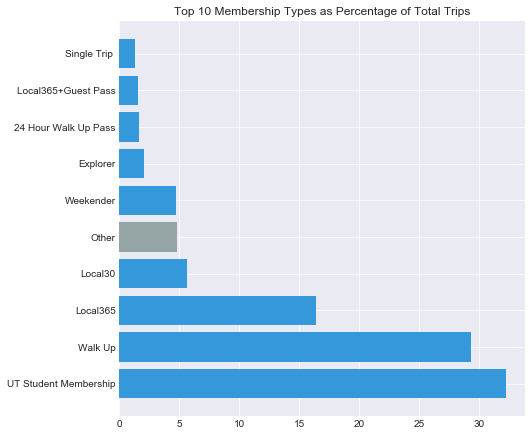

In [333]:
plt.style.use('seaborn-colorblind')

# Plot the top memberships
top_9_memberships = (trips['membership_type'].value_counts(normalize=True).sort_values(ascending=False)*100).head(9)
memberships = trips['membership_type'].apply(lambda x: x if x in top_9_memberships else 'Other')     # Aggregate remaining memberships as 'Other'
top_10_memberships_and_others = (memberships.value_counts(normalize=True).sort_values(ascending=False)*100).head(10)

fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(2, 2, 1)
ax1.barh(top_10_memberships_and_others.index, top_10_memberships_and_others, color = ["#95a5a6" if i==4 else "#3498db" for i in range(len(top_10_memberships_and_others))])

ax1.set_title("Top 10 Membership Types as Percentage of Total Trips")
ax1.tick_params(axis=u'both', which=u'both',length=0)
for key, spine in ax1.spines.items():
    spine.set_visible(False)

plt.show()


In the plot above we see that UT Student, Walk Up, and Local365 members take the most trips.

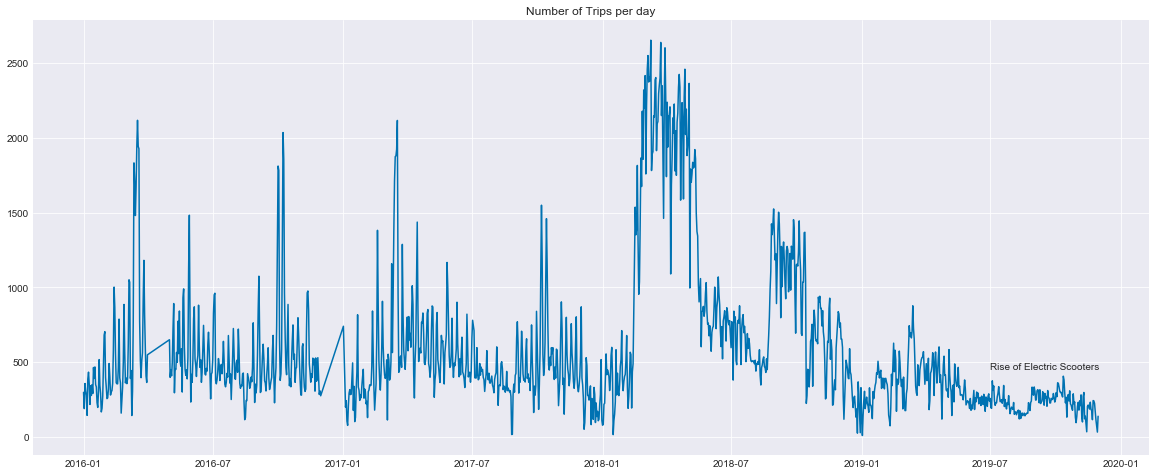

In [334]:
plt.style.use('seaborn-darkgrid')

fig = plt.figure(figsize=(20, 8))

# Create a time series plot of trips per day
ax = fig.add_subplot(111)
ax.plot(trips.groupby(['checkout_date']).size())
ax.set_title('Number of Trips per day')
ax.annotate('Rise of Electric Scooters', (date(2019, 7, 1), 450))

plt.show()
# This plot reveals that there is missing data for April 2016 and December 2016


One noticeable takeaway from this time series is the absence of data for April 2016 and December 2016. Missing data for the historically high traffic month of April will lead to an artificially deflated yearly total for 2016. Aside from that we see the seasonal nature of BCycle rentals, which we will look into more later. We also notice that 2018 saw a huge influx of BCyclye use but 2019 dropped off significantly as electric scooters became mainstream.

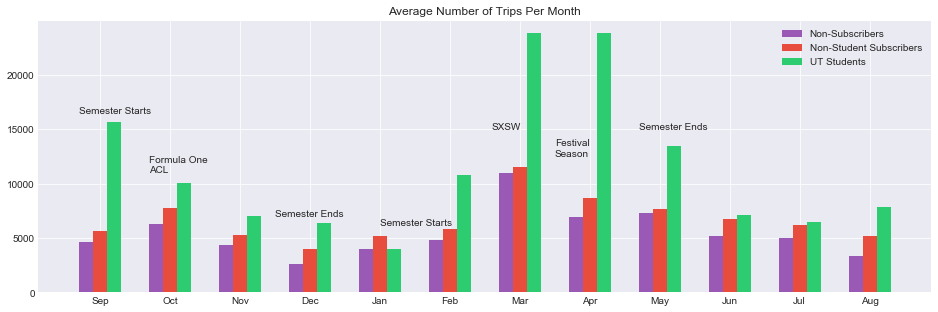

In [335]:
# plot average number of trips by month
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)

walk_ups = trips[trips['membership_type'].isin(['Walk Up','Single Trip'])]
non_walk_ups = trips[~trips['membership_type'].isin(['Walk Up','Single Trip', 'UT Student Membership'])]
students = trips[trips['membership_type']=='UT Student Membership']

walk_ups_avg_trips_by_month = walk_ups.groupby(['year','month']).size().groupby('month').mean()[[9,10,11,12,1,2,3,4,5,6,7,8]]
non_walk_ups_avg_trips_by_month = non_walk_ups.groupby(['year','month']).size().groupby('month').mean()[[9,10,11,12,1,2,3,4,5,6,7,8]]
students_avg_trips_by_month = students.groupby(['year','month']).size().groupby('month').mean()[[9,10,11,12,1,2,3,4,5,6,7,8]]

ind = np.arange(1, 13)
ax.bar(ind-.2, walk_ups_avg_trips_by_month, width=.2, color="#9b59b6", align='center', label='Non-Subscribers')
ax.bar(ind, non_walk_ups_avg_trips_by_month,  width=.2,color="#e74c3c", align='center', label='Non-Student Subscribers')
ax.bar(ind+.2, students_avg_trips_by_month, width=.2, color="#2ecc71", align='center', label='UT Students')

ax.annotate("ACL", (1.7, 11000))
ax.annotate("Formula One", (1.7, 12000))
ax.annotate("SXSW", (6.6, 15000))
ax.annotate("Festival", (7.5, 13500))
ax.annotate("Season", (7.5, 12500))
ax.annotate("Semester Starts", (.7, 16500))
ax.annotate("Semester Ends", (8.7, 15000))
ax.annotate("Semester Starts", (5, 6200))
ax.annotate("Semester Ends", (3.5, 7000))

ax.set_title("Average Number of Trips Per Month")
ax.set_xticks(range(1,13))
ax.set_xticklabels(['Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug'])
ax.legend()
for key, spine in ax.spines.items():
    spine.set_visible(False)

plt.show()

Here we see the cyclical nature of number of trips taken, aggregated by month and membership_type, relative to the UT class schedule. While Non-Subscribers and Non-Students useage stays closely grouped, the usage of students swings violently. Student useage starts off high for the first week of classes, continues to drop throughout the semester until surging when classes pick up again in February. Students also seem to be most likely to ride to local events during the busy months of March and April. Their useage then declines as classes wrap up in May. 

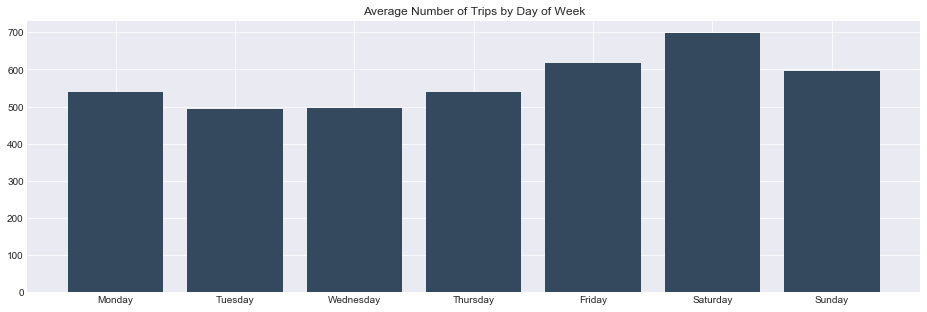

In [336]:
# Plot average number of trips by day
# Create a temporary dataframe storing all of the weekdays that existed during time period of the dataset

def date_generator(date1, date2):     # Generator that takes a start date and end date as input and returns a list of all dates in between
    for n in range(int((date2 - date1).days)+1):
        yield date1 + timedelta(n)
        
all_dates = []
start = trips['checkout_date'].dt.date.min()  
end = trips['checkout_date'].dt.date.max()
for dt in date_generator(start, end):
    all_dates.append(dt)

temp_date_df = pd.DataFrame({'all_dates': all_dates})
temp_date_df['all_dates'] = pd.to_datetime(temp_date_df['all_dates'])

temp_date_df['weekday'] = temp_date_df['all_dates'].dt.weekday.map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday',5:'Saturday', 6:'Sunday'})

# Divide total trips for each weekday by the total number of weekdays to find the average use
trips_per_day_of_week = trips['weekday'].value_counts() / temp_date_df['weekday'].value_counts()

# Reorder days chronologically 
trips_per_day_of_week = trips_per_day_of_week.reindex(index=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

# make plot
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
ax.bar(trips_per_day_of_week.index, trips_per_day_of_week, color="#34495e")

ax.set_title("Average Number of Trips by Day of Week")
ax.tick_params(axis=u'both', which=u'both',length=0)
for key, spine in ax.spines.items():
    spine.set_visible(False)

plt.show()

In this plot, unsurprisingly, we see the bulk of use occurring on Fridays, Saturdays, and Sundays. 

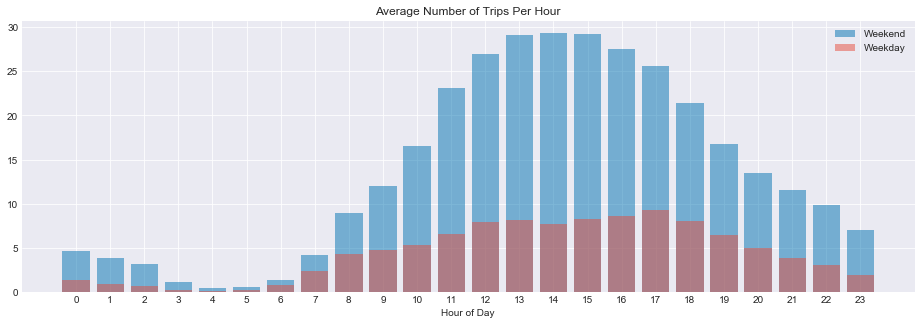

In [362]:

# Plot Average number of trips by time of day
# Find total number of hours during time period (needed to find the average per hour)

#all_dates = temp_date_df[temp_date_df['all_dates'] >= trips['checkout_date'].min()].copy()
temp_date_df['hour'] = [range(24) for x in range(len(temp_date_df))]

def expand_row(df):
    lens = [len(item) for item in df['hour']]
    return pd.DataFrame( {"all_dates" : np.repeat(df['all_dates'].values,lens),
                          "weekday" : np.repeat(df['weekday'].values,lens),
                          "hour" : np.concatenate(df['hour'].values)})

temp_hours_df = expand_row(temp_date_df)

total_weekend_hours = temp_hours_df[temp_hours_df['weekday'].isin(['Friday','Saturday'])]
total_weekend_hours = total_weekend_hours.groupby('hour').size()

total_weekday_hours = temp_hours_df[~temp_hours_df['weekday'].isin(['Friday','Saturday'])]
total_weekday_hours = total_weekday_hours.groupby('hour').size()


weekend_trips_by_hour = trips[trips['weekday'].isin(['Friday','Saturday'])].groupby('hour').size()
weekday_trips_by_hour = trips[~trips['weekday'].isin(['Friday','Saturday'])].groupby('hour').size()

weekend_avg_per_hour = weekend_trips_by_hour / total_weekend_hours
weekday_avg_per_hour = weekday_trips_by_hour / total_weekday_hours

fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(111)
bar1 = ax.bar(weekend_avg_per_hour.index, weekend_avg_per_hour / 2, alpha=.5)
bar2 = ax.bar(weekday_avg_per_hour.index, weekday_avg_per_hour / 5, color="#e74c3c", alpha=.5)
ax.legend((bar1, bar2), ('Weekend', 'Weekday'))
ax.set_xticks(range(24))
ax.set_title('Average Number of Trips Per Hour')
ax.set_xlabel("Hour of Day")
plt.show()


This plot divides trips into weekday and weekend use. Weekday use plateaus between 12pm and 6pm, with few users willing to use the service late at night or early morning. Weekend use, however, is much higher across the spectrum, peaks from 1pm to 3pm, and is much more likely to extend late into the night.
Now that we have a broad overview of the data, we can inspect more closely. First we will address these excessively long trips (ranging from 300 minutes to 34,238 minutes) to see if there are any correlations between these trips and the checkout kiosk, indicating that there may be a problem with the kiosk or how users interact with that kiosk. We will focus on the top 10 kiosks by amount of trips.


In [363]:
print('Min trip length of long trips:', long_trips['trip_length_minutes'].min())
print('Max trip length of long trips:', long_trips['trip_length_minutes'].max())

# Compare the excessively long trips vs all trips
long_trips_count = long_trips['checkout_kiosk'].value_counts(normalize=True)
all_trips_count = trips['checkout_kiosk'].value_counts(normalize=True)

long_trips_and_all_trips = pd.concat([long_trip_df, all_trips_df], ignore_index=False, axis=1, sort=False)
long_trips_and_all_trips.columns = ['long_trips_pct', 'all_trips_pct']
long_trips_and_all_trips = long_trips_and_all_trips.sort_values('long_trips_pct', ascending=False).fillna(0)

print(long_trips_and_all_trips)

# Find the p-values for the hypothesis that the value count proportions should be the same between the two data
top_10_long_trip_kiosks = long_trips_and_all_trips['long_trips_pct'][0:10]       # Focus on the 10 kiosks with the most long trips
p_values = {}

for ind, kiosk_pct in enumerate(top_10_long_trip_kiosks):
    kiosk = top_10_long_trip_kiosks.index[ind]
    p = kiosk_pct
    mu = long_trips_and_all_trips['all_trips_pct'].loc[kiosk]
    N = len(long_trips)

    se = np.sqrt(p * (1 - p) / N)
    z = (p - mu) / se
    p_values[kiosk] = norm.sf(abs(z)) * 2   # two tail test


# Using a 95% confidence interval, find the membership_type's that depart from the upper range of acceptable variation of the population mean
problem_kiosks = dict((key, value) for (key, value) in p_values.items() if ((value < .05) 
                                                                        and (long_trips_and_all_trips.loc[key, 'long_trips_pct'] > long_trips_and_all_trips.loc[key, 'all_trips_pct'])))
print('Outliers:', problem_kiosks)


Min trip length of long trips: 61
Max trip length of long trips: 300
                                                    long_trips_pct  \
21st & speedway @pcl                                      0.103672   
guadalupe & 21st                                          0.035400   
dean keeton & speedway                                    0.031427   
davis & rainey                                            0.029741   
riverside & south lamar                                   0.028657   
rainey & cummings                                         0.027092   
rio grande & 28th                                         0.026129   
brazos & 6th                                              0.025166   
ut west mall & guadalupe                                  0.023841   
23rd & rio grande                                         0.023359   
nueces & 26th                                             0.023119   
capitol station & congress & 11th                         0.021072   
21st & university    

We can reject the null hypothesis that the proportions are the same for long trips vs all trips for the outliers above. These kiosks exhibited an unusually high amount of long trips. These kiosks could benefit from a system inspection and/or a user survey to get feedback on UX problems.

Is there evidence that users mistakenly take long trips, under the impression that they have unlimited use? In this instance we will consider long trips as between 60 and 300 minutes. We've already segregated trips lasting longer than 300 minutes due to their questionable integrity. We can test whether the percentage of walk up 24hr pass users is the same for short or long trips, in line with the pricing structure.

In [364]:
print("Average Trip Length: ", trips['trip_length_minutes'].mean())

long_trips = trips[trips['trip_length_minutes'] > 60]

long_trip_membership_count = long_trips['membership_type'].value_counts(normalize=True)
all_trips_membership_count = trips['membership_type'].value_counts(normalize=True)

day_pass = long_trip_membership_count['24 Hour Walk Up Pass']
all_trips = all_trips_membership_count['24 Hour Walk Up Pass']

# Find the p-values for the hypothesis that the value count proportions should be the same between the two data

p = day_pass
mu = all_trips
N = len(long_trips)

se = np.sqrt(p * (1 - p) / N)
z = (p - mu) / se
p_value = norm.sf(abs(z)) * 2   # two tail test

print('Percent of Memberships for long trips that are day pass:', day_pass*100)
print('Percent of all Memberships that are day pass:', all_trips*100)
print('P-value:', p_value)


Average Trip Length:  22.65628621124858
Percent of Memberships for long trips that are day pass: 5.100182149362477
Percent of all Memberships that are day pass: 1.6842612843783904
P-value: 0.0


We see that the percentage of day passes is over 3 times as much for long trips, rather than short trips. Because of this large discrepancy, and the large sample size, we get a p-value of 0. We should note, however, that the actual p-value is infinitesimally small, but not quite 0. It does prove without a doubt that day pass users are much more likely to take expensive long trips, which would give credence to reviewers who say the rules are unclear. BCycles should go above and beyond to make this absolutely clear during purchase, to maintain customer satisfaction. Let us now inspect the data for very short trips. 

In [365]:

# Create a dataframe to compare the distribution of kiosk locations for 0 minute trips vs all trips
zero_min_kiosk_count = zero_min_trips['checkout_kiosk'].value_counts(normalize=True)
#zero_min_df = pd.DataFrame({'zero_min_pct': zero_min_kiosk_count.values}, index=zero_min_kiosk_count.index)

zero_min_and_all_trips = pd.concat([zero_min_kiosk_count, all_trips_count], ignore_index=False, axis=1, sort=False)
zero_min_and_all_trips.columns = ['zero_min_pct','all_trips_pct']
zero_min_and_all_trips = zero_min_and_all_trips.sort_values('zero_min_pct', ascending=False).fillna(0)

print(zero_min_and_all_trips)

# Find the p-values for the hypothesis that the value count proportions should be the same between the two data
top_10_zero_min_trip_kiosks = zero_min_and_all_trips['zero_min_pct'][0:10]       # Focus on the 10 kiosks with the most 0 minute trips

p_values = {}

for ind, kiosk_pct in enumerate(top_10_zero_min_trip_kiosks):
    kiosk = top_10_zero_min_trip_kiosks.index[ind]
    p = kiosk_pct
    mu = zero_min_and_all_trips['all_trips_pct'].loc[kiosk]
    N = len(zero_min_trips)

    se = np.sqrt(p * (1 - p) / N)
    z = (p - mu) / se
    p_values[kiosk] = norm.sf(abs(z)) * 2   # two tail test


# Using a 95% confidence interval, find the membership_type's that depart from the upper range of the acceptable variation of the population mean
problem_kiosks = dict((key, value) for (key, value) in p_values.items() if ((value < .05) 
                                                                        and (zero_min_and_all_trips.loc[key, 'zero_min_pct'] > zero_min_and_all_trips.loc[key, 'all_trips_pct'])))
print('Outliers:', problem_kiosks)



zero_min_pct  \
21st & speedway @pcl                                    0.140729   
23rd & san jacinto & dkr stadium                        0.036105   
23rd & rio grande                                       0.029461   
dean keeton & speedway                                  0.028857   
22nd & pearl                                            0.028454   
city hall & lavaca & 2nd                                0.026575   
mopac pedestrian bridge & veterans                      0.025904   
davis & rainey                                          0.024898   
riverside & south lamar                                 0.023891   
guadalupe & 21st                                        0.023153   
21st & university                                       0.022213   
rio grande & 28th                                       0.022012   
ut west mall & guadalupe                                0.021207   
rainey & cummings                                       0.021005   
5th & bowie                     

Again, we see very peculiar data for the city's most heavily used kiosk, '21st & speedway @pcl'. Is it possible that this kiosk doesn't have sufficient bandwidth? For example, perhaps there is so little time between users that the system is not ready to accept the new user, leading to problems. 

Surprisingly, there is a below average amount of 'Walk Up' users that have 0 minute trips. It would be expected that this would be the bulk of novice users, who may be prone to user error.
We will investigate to see if specific memberships are having difficulty.


In [366]:
# Combine a dataframe to compare membership_type zero minute trips vs all trips
zero_min_trips_count = zero_min_trips['membership_type'].value_counts(normalize=True)
all_trips_count = trips['membership_type'].value_counts(normalize=True)

zero_min_and_all_trips_membership = pd.concat([zero_min_trips_count, all_trips_count], ignore_index=False, axis=1)
zero_min_and_all_trips_membership.columns = ['zero_min_pct','all_trips_pct']
zero_min_and_all_trips_membership = zero_min_and_all_trips_membership.sort_values('zero_min_pct', ascending=False).fillna(0)

print(zero_min_and_all_trips_membership)

# Find the p-values for the hypothesis that the variation between the proportions is normal
top_10_zero_min_memberships = zero_min_and_all_trips_membership['zero_min_pct'][0:10]
p_values = {}

for ind, membership in enumerate(top_10_zero_min_memberships):
    membership_type = top_10_zero_min_memberships.index[ind]
    p = membership
    mu = zero_min_and_all_trips_membership['all_trips_pct'].loc[membership_type]
    N = len(zero_min_trips)

    se = np.sqrt(p * (1 - p) / N)
    z = (p - mu) / se
    p_values[membership_type] = norm.sf(z) * 2   # two tail test

problem_memberships = dict((key, value) for (key, value) in p_values.items() if value < .05 )
print(problem_memberships)


zero_min_pct  \
U.T. Student Membership                                 0.387021   
Walk Up                                                 0.240789   
Local365                                                0.136031   
unknown                                                 0.065767   
Local30                                                 0.051406   
Weekender                                               0.036843   
Explorer                                                0.019730   
Local365+Guest Pass                                     0.012684   
Single Trip                                             0.008120   
24 Hour Walk Up Pass                                    0.006979   
3-Day Explorer                                          0.004631   
Single Trip                                             0.004094   
Local365 ($80 plus tax)                                 0.003691   
$1 Pay by Trip Winter Special                           0.003288   
Local365- 1/2 off Anniversary Sp

Three types of user's particularly are having trouble with trips lasting 0 minutes. UT students are having difficulty, which would corroborate previous testing that shows 4 of the problem kiosks are on campus. However, this does not make it clear whether the problem is the student or the on campus kiosks, as the two are highly correlated. There is a significant correlation between these problem trips and memberships listed as 'Unknown,' which are trips where no membership_type was included. Finally, to a lesser extent, Single Trip users also experienced more than their fair share of issues. This makes sense, as these users are most likely to be new to using the platform. Perhaps these problem kiosks could benefit from more testing to ensure proper function.


In [384]:
# Introduce variable pricing structure (like Uber's surge pricing) that rewards customers reversing the traffic flow based on the date/time to help with Rebalancing issue
# The best way to implement an algorithm would be to combine real time availability of kiosks (which is available on the app) with short term demand for kiosks. For now we will implement a very rudimentary algorithm based on historical traffic flows (not accounting for special events) to propose some incentive for users to help rebalance the kiosks
from datetime import datetime

trips.groupby(['checkout_kiosk', 'return_kiosk']).size()
trips['checkout_return_pair'] = trips['checkout_kiosk'] + ', ' + trips['return_kiosk']
trips['checkout_return_pair'].value_counts()

def populate_current_data():    # Returns the trips dataframe filtered by the current day and current hour
    current_time = datetime.now()
    current_day = datetime.now().today().weekday()
    current_hour = current_time.hour

    df = pd.DataFrame(columns=['weekday','hour'])
    df['weekday'] = trips['weekday'].map({'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4,'Saturday':5, 'Sunday':6})
    df['hour'] = [x.hour for x in trips['checkout_time']]
    return trips[(df['weekday'] == current_day) & (df['hour'] == current_hour)]

def checkout_discount():        # Returns the kiosks that rank in the bottom 25% of kiosks for checkouts at current day of week and hour. BCycles could offer a discount for riders that checkout at these kiosks.
    relevant_trips = populate_current_data()
    
    checkout_demand = relevant_trips['checkout_kiosk'].value_counts()       # find overused and underused kiosks
    
    quartile = int(len(checkout_demand) / 4)
    bottom_quartile_checkout_demand = checkout_demand[-quartile:]

    return bottom_quartile_checkout_demand

def return_discount():        # Returns the kiosks that rank in the bottom 25% of kiosks for returns at current day of week and hour. BCycles could offer a discount for riders that return at these kiosks.
    relevant_trips = populate_current_data()
    
    return_demand = relevant_trips['return_kiosk'].value_counts()       # find overused and underused kiosks
    
    quartile = int(len(return_demand) / 4)
    bottom_quartile_return_demand = return_demand[-quartile:]
    
    return bottom_quartile_return_demand

print(checkout_discount())
print(return_discount())

republic square & guadalupe & 4th    14
acc - west & 12th                    12
5th & campbell                       11
guadalupe & 6th                      10
11th & salina                        10
lake austin & enfield                10
east 7th & pleasant valley           10
lake austin blvd & deep eddy          9
red river & cesar chz & fairmont      8
pease park                            7
waller & 6th                          7
hollow creek & barton hills           6
nash hernandez & rbj south            5
10th & red river                      5
6th & chalmers                        4
rosewood & angelina                   3
south congress & bouldin creek        2
office & main & shop & repair         2
8th & lavaca                          2
zilker park west                      2
rosewood & chicon                     1
republic square                       1
Name: checkout_kiosk, dtype: int64
21st & speedway @pcl                                  828
dean keeton & speedway     

In [385]:
# Let's look into Missing/Stolen Bicycles to see if we can reduce loss
print(trips[trips['return_kiosk'] == 'Missing or Stolen'])
print(trips[trips['return_kiosk'] == 'Missing or Stolen']['trip_length_minutes'].mean())

Empty DataFrame
Columns: [trip_id, membership_type, bicycle_id, checkout_date, checkout_time, checkout_kiosk_id, checkout_kiosk, return_kiosk_id, return_kiosk, trip_length_minutes, month, year, hour, weekday, checkout_return_pair]
Index: []
nan


In [ ]:
trips.to_csv('trips_revised.csv')   # For tableau manipulation

In [389]:
trips[trips['return_kiosk'].isin('missing')]

TypeError: only list-like objects are allowed to be passed to isin(), you passed a [str]

Which bikes are due to be retired?

In [ ]:
# Print list of bicycle_id's that have had over 50,000 minutes of use
bikes_by_total_minutes = trips.groupby('bicycle_id')['trip_length_minutes'].sum().sort_values(ascending=False)
bikes_over_50k_minutes = bikes_by_total_minutes[bikes_by_total_minutes > 50000]
bikes_over_50k_minutes